In [1]:
import sys
import os

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory) 
sys.path.append(parent_directory)

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [3]:
from preprocess.BaselinePrerocess import baseline_process
from preprocess.BaselinePrerocess import gcn_process_for_gate_predictor, baseline_process_for_gate_predictor
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process
from preprocess.GraphTransformerPrerocess import graph_global_transformer_local_process
from preprocess.GraphTransformerPrerocess import graph_water_transformer_cov_process_for_gate_predictor
from preprocess.graph import graph_topology, graph_topology_5
from tensorflow.keras.models import load_model
from postprocess.threshold import flood_threshold, drought_threshold, flood_threshold_t1, drought_threshold_t1
from postprocess.errors import estimate_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from math import sqrt
from spektral.layers import GCNConv
from baselines.tcn import TCN
from preprocess.helper import series_to_supervised
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from losses.loss import gate_loss, water_level_threshold

2023-08-14 20:46:47.502997: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-14 20:46:48.827066: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Data Preprocessing

In [4]:
# ====== preprocessing parameters ======
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [5]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

print(train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
(77069, 96, 16) (9634, 96, 16) (19268, 96, 16) (77069, 96) (9634, 96) (19268, 96)


## Pick 09/03/2019 09:00 - 09/04/2019 03:00

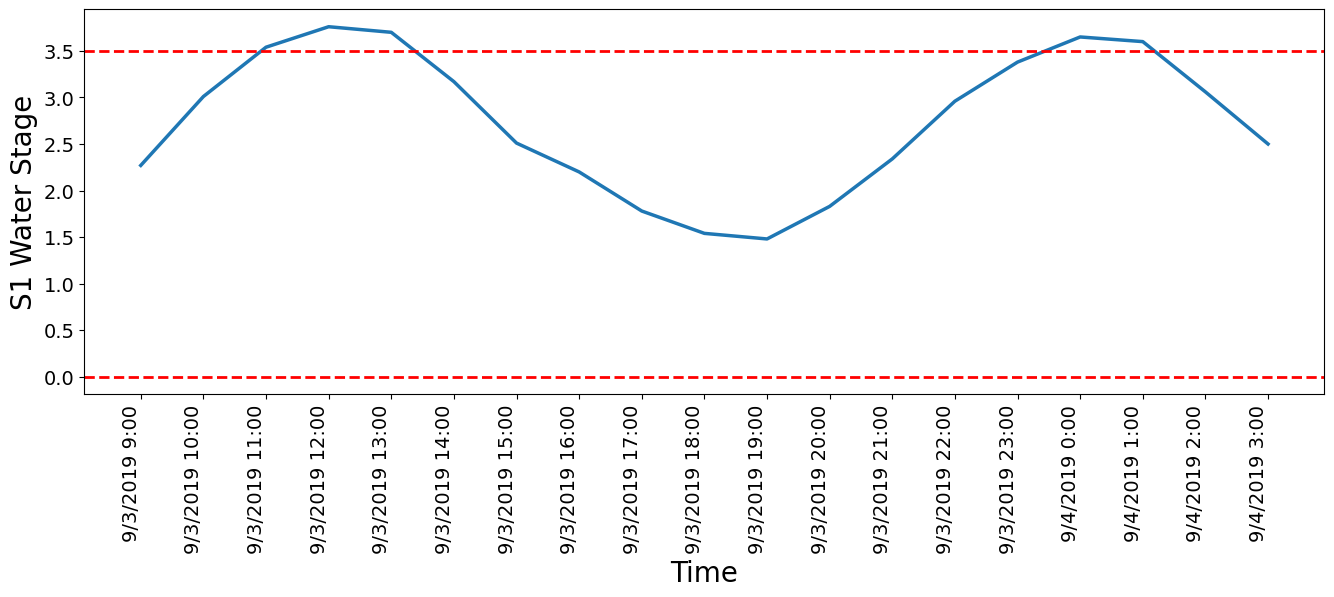

In [6]:
event_Sep3 = pd.read_csv('../data/one_flood_event.csv', index_col=0)

plt.rcParams["figure.figsize"] = (16, 5)
plt.plot(event_Sep3.iloc[11:, 0], linewidth=2.5)
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.axhline(y = 0, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=20)
plt.ylabel('S1 Water Stage', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(rotation=90, ha='right')
plt.show()

In [7]:
### get the same day from test set
inv_y = ws_scaler.inverse_transform(test_ws_y)
inv_y = inv_y.reshape((-1, 24, 4))
inv_y.shape

(19268, 24, 4)

In [8]:
loc_id = 0
time_id = 1
start_idx = 7624+11
end_idx = 7654

In [9]:
inv_y[start_idx:end_idx, time_id, loc_id].shape

(19,)

### Visualize ground_truth & GA_HEC-RAS

In [10]:
ga_hecras = pd.read_csv('../data/GA_HECRAS_water_results.csv')

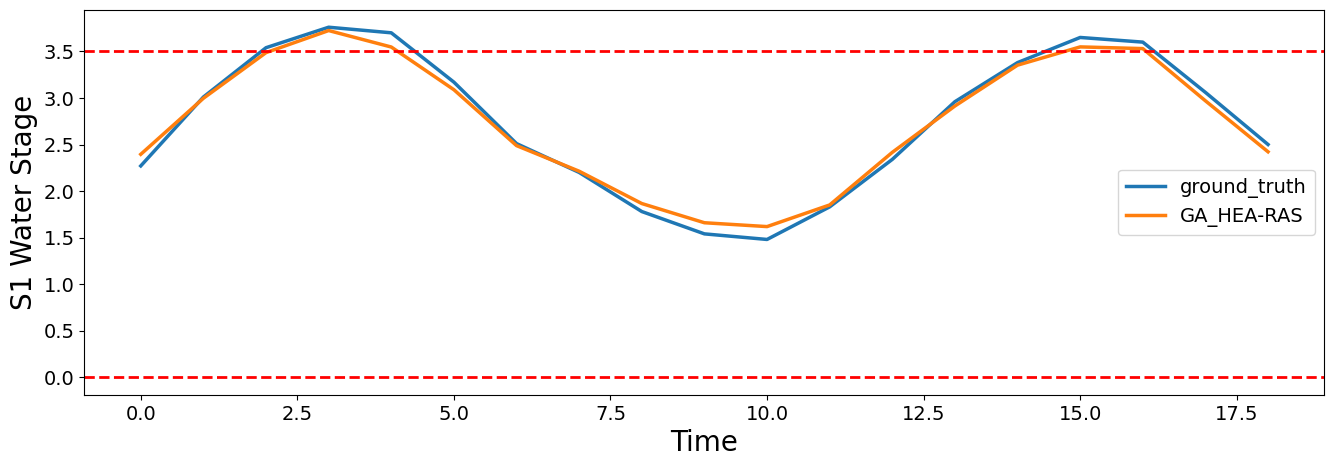

In [11]:
plt.rcParams["figure.figsize"] = (16, 5)
plt.plot(inv_y[start_idx:end_idx, time_id, loc_id], linewidth=2.5, label='ground_truth')
plt.plot([i for i in range(19)], ga_hecras.iloc[11:, loc_id], linewidth=2.5, label='GA_HEA-RAS')
plt.axhline(y = 3.5, color='r', linestyle='dashed', linewidth=2)
plt.axhline(y = 0, color='r', linestyle='dashed', linewidth=2)
plt.xlabel('Time', fontsize=20)
plt.ylabel('S1 Water Stage', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

## Import trained models & predict the outputs of each model for flood mitigation

### FloodGTN

In [12]:
n_hours = 72
K = 24 
masked_value = 1e-10
split_1 = 0.8
split_2 = 0.9
sigma2 = 0.1
epsilon = 0.5

In [13]:
train_cov, val_cov, test_cov, \
train_tws_reshape, val_tws_reshape, test_tws_reshape, \
train_gate_pump_y, val_gate_pump_y, test_gate_pump_y, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler, gate_scalar = graph_water_transformer_cov_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_tws/val_tws/test_tws: (77069, 5, 72) (9634, 5, 72) (19268, 5, 72) 
 train_cov/val_cov/test_cov: (77069, 96, 12) (9634, 96, 12) (19268, 96, 12) 
 train_ws_y/val_ws_y/test_ws_y: (77069, 96) (9634, 96) (19268, 96) 
  train_gate_pump_y/val_gate_pump_y/test_gate_pump_y: (77069, 24, 7) (9634, 24, 7) (19268, 24, 7)


In [14]:
train_adj_mat, val_adj_mat, test_adj_mat = graph_topology_5(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [0 0 0 0 1 1 2 2 3 3 4 4] 
neighbor_indices: [1 2 3 4 0 2 0 1 0 4 0 3]
number of nodes: 5, number of edges: 12


In [15]:
floodgtn = load_model('../saved_models/gtnp_gtnp_13.h5',
                       custom_objects={'gate_loss':gate_loss, 
                                       'water_level_threshold':water_level_threshold,
                                       'GCNConv': GCNConv
                                      }
                      )

2023-08-14 20:47:02.884543: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10402 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:08:00.0, compute capability: 6.1


In [16]:
gate_pump_pred_floodgtn, ws_pred_floodgtn = floodgtn.predict([test_cov, test_tws_reshape, test_adj_mat])
ws_pred_floodgtn = ws_scaler.inverse_transform(ws_pred_floodgtn)
ws_pred_floodgtn = ws_pred_floodgtn.reshape((-1, 24, 4))

print(gate_pump_pred_floodgtn.shape)
print(ws_pred_floodgtn.shape)

2023-08-14 20:47:06.568182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600


603/603 [==============================] - 6s 6ms/step
(19268, 24, 7)
(19268, 24, 4)


### TCN

In [17]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
scaler, ws_scaler = baseline_process(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')


In [18]:
tcn = load_model('../saved_models/tcn_gtnp_1.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv,
                                         'TCN': TCN
                                        }
                        )

In [19]:
gate_pump_pred_tcn, ws_pred_tcn = tcn.predict([test_X_mask, test_tws_reshape, test_adj_mat])
ws_pred_tcn = ws_scaler.inverse_transform(ws_pred_tcn)
ws_pred_tcn = ws_pred_tcn.reshape((-1, 24, 4))

print(gate_pump_pred_tcn.shape)
print(ws_pred_tcn.shape)

603/603 [==============================] - 6s 8ms/step
(19268, 24, 7)
(19268, 24, 4)


### GCN

In [20]:
train_X_mask, val_X_mask, test_X_mask, \
train_ws_y, val_ws_y, test_ws_y, \
train_gate_y, val_gate_y, test_gate_y, \
scaler, ws_scaler, gate_scaler = gcn_process_for_gate_predictor(n_hours, K, masked_value, split_1, split_2)

Index(['WS_S1', 'WS_S4', 'FLOW_S25A', 'GATE_S25A', 'HWS_S25A', 'TWS_S25A',
       'FLOW_S25B', 'GATE_S25B', 'GATE_S25B2', 'HWS_S25B', 'TWS_S25B',
       'PUMP_S25B', 'FLOW_S26', 'GATE_S26_1', 'GATE_S26_2', 'HWS_S26',
       'TWS_S26', 'PUMP_S26', 'MEAN_RAIN'],
      dtype='object')
train_X_mask.shape, val_X_mask.shape, test_X_mask.shape, train_ws_y.shape, val_ws_y.shape, test_ws_y.shape, train_gate_y.shape, val_gate_y.shape, test_gate_y.shape: (77069, 14, 96) (9634, 14, 96) (19268, 14, 96) (77069, 96) (9634, 96) (19268, 96) (77069, 24, 5) (9634, 24, 5) (19268, 24, 5)


In [21]:
train_adj_mat_gcn, val_adj_mat_gcn, test_adj_mat_gcn = graph_topology(n_hours, K, sigma2, epsilon, len(train_ws_y), len(val_ws_y), len(test_ws_y))

node_indices: [ 0  0  0  0  0  1  1  1  2  2  2  3  3  4  4  4  4  5  5  5  6  6  6  7
  7  7  8  8  8  8  8  9  9  9 10 10 10 11 11 11 12 12 12 12 13 13 13 13
 13 13 13 13 13 13 13 13 13 13] 
neighbor_indices: [ 1  4  8 12 13  1  4 13  3  4 13  2 13  0  1  2 13  7  8 13  7  8 13  5
  6 13  0  5  6 12 13 11 12 13 11 12 13  9 10 13  0  9 10 13  0  1  2  3
  4  5  6  7  8  9 10 11 12 13]
number of nodes: 14, number of edges: 58


In [22]:
gcn = load_model('../saved_models/gcn_gtnp_1.h5',
                         custom_objects={'gate_loss':gate_loss, 
                                         'water_level_threshold':water_level_threshold,
                                         'GCNConv': GCNConv
                                        }
                        )

In [23]:
gate_pump_pred_gcn, ws_pred_gcn = gcn.predict([test_X_mask, test_adj_mat_gcn, test_tws_reshape, test_adj_mat])
ws_pred_gcn = ws_scaler.inverse_transform(ws_pred_gcn)
ws_pred_gcn = ws_pred_gcn.reshape((-1, 24, 4))

print(gate_pump_pred_gcn.shape)
print(ws_pred_gcn.shape)

603/603 [==============================] - 4s 6ms/step
(19268, 24, 7)
(19268, 24, 4)


### Visualize water level & gate

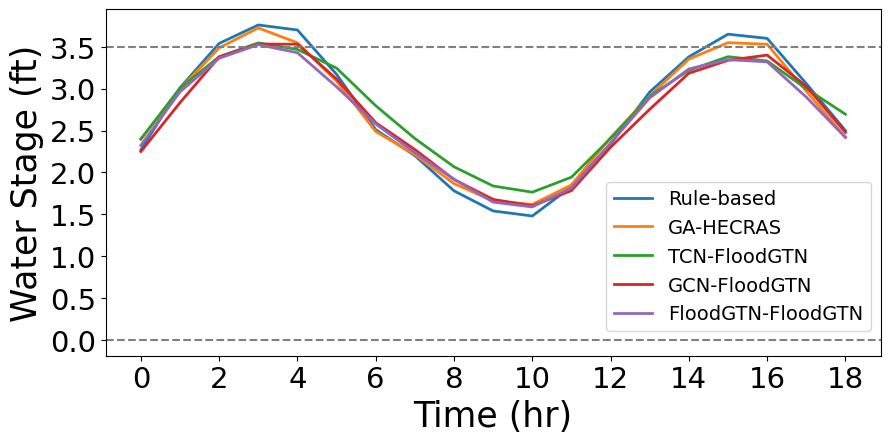

In [32]:
xticks = [i for i in range(0, 20, 2)]
plt.rcParams["figure.figsize"] = (10, 4.5)
LINE_WIDTH = 2
TICK_SIZE = 21
LABEL_SIZE = 25
LEGEND_SIZE = 14

loc_id = 0
# for i in range(4):
plt.plot(inv_y[start_idx:end_idx, time_id, loc_id], linewidth=LINE_WIDTH, label='Rule-based')
plt.plot([i for i in range(19)], ga_hecras.iloc[11:, loc_id], linewidth=LINE_WIDTH, label='GA-HECRAS')
plt.plot(ws_pred_tcn[start_idx:end_idx, time_id, loc_id], linewidth=LINE_WIDTH, label='TCN-FloodGTN')
plt.plot(ws_pred_gcn[start_idx:end_idx, time_id, loc_id], linewidth=LINE_WIDTH, label='GCN-FloodGTN')
plt.plot(ws_pred_floodgtn[start_idx:end_idx, time_id, loc_id], linewidth=LINE_WIDTH, label='FloodGTN-FloodGTN')

plt.axhline(y = 3.5, linestyle='dashed', linewidth=1.5, color='gray')
plt.axhline(y = 0, linestyle='dashed', linewidth=1.5, color='gray')
plt.xlabel('Time (hr)', fontsize=LABEL_SIZE)
plt.ylabel('Water Stage (ft)', fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.xticks(xticks[::1])
plt.legend(fontsize=LEGEND_SIZE,  bbox_to_anchor=(0.5, 0.03, 0.5, 0.5))  # bbox (x, y, width, height)
# plt.savefig('flood_mitigation.png', dpi=300, bbox_inches='tight')
plt.show()

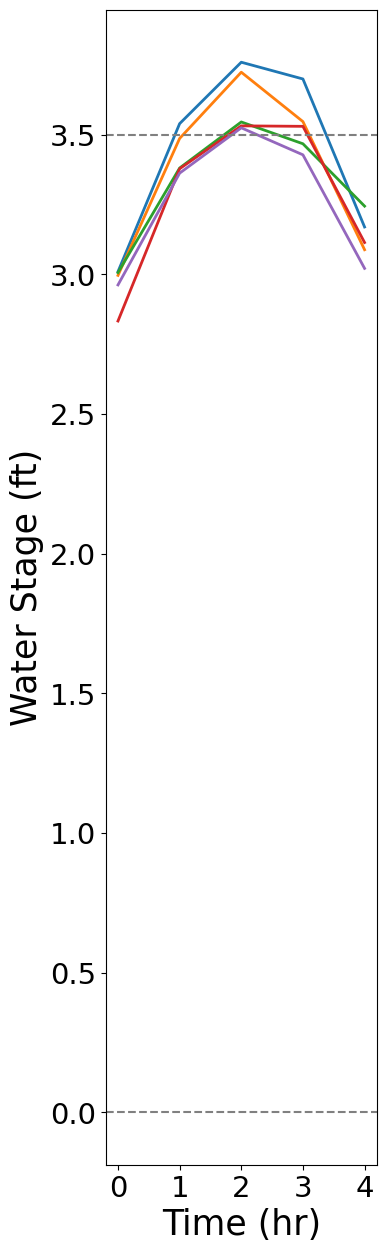

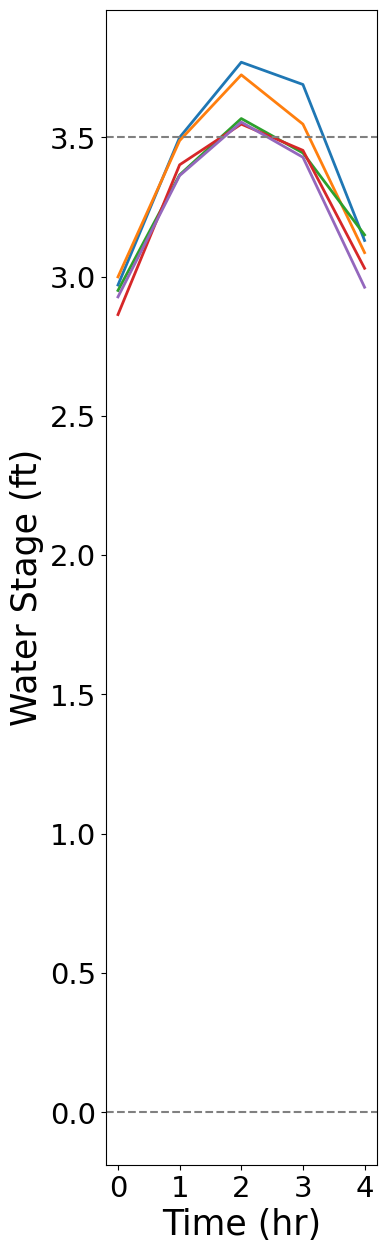

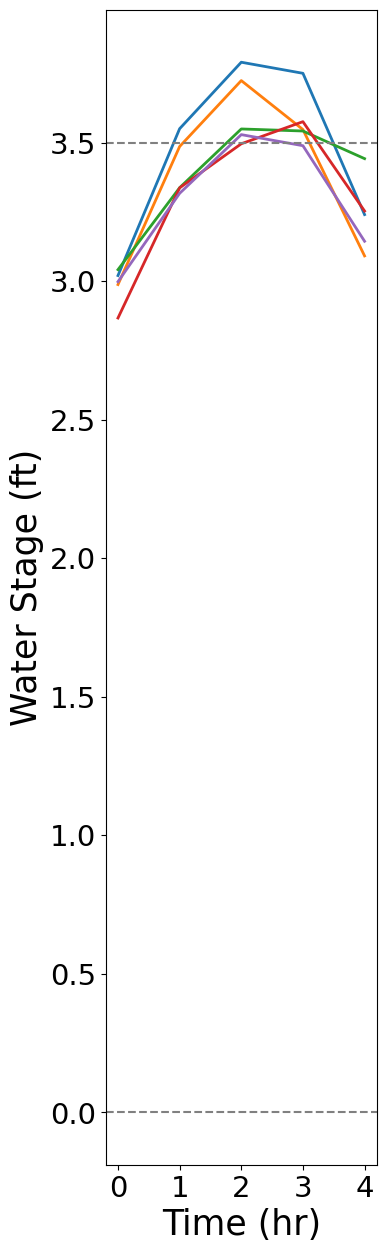

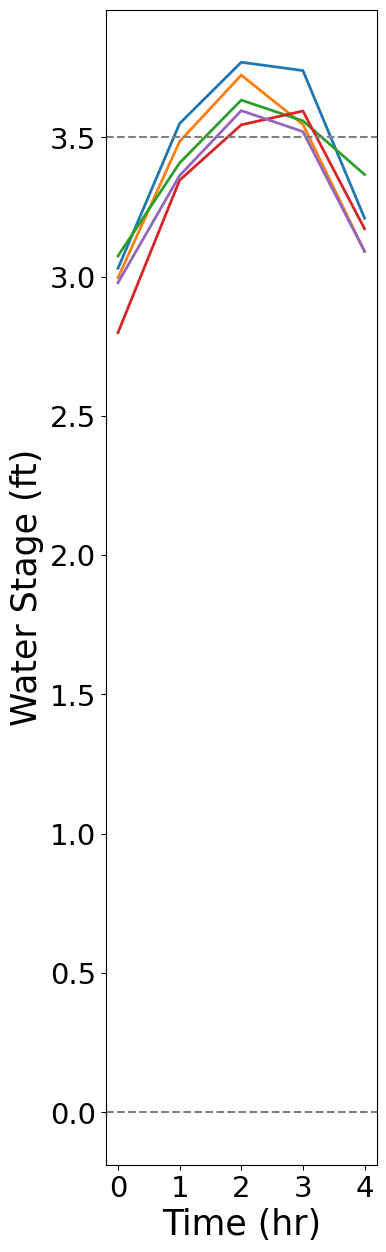

In [31]:
for i in range(4):
    plt.rcParams["figure.figsize"] = (3.5, 15)
    plt.plot([0, 1, 2, 3, 4], inv_y[start_idx+1:start_idx+6, time_id, i], linewidth=LINE_WIDTH, label='Rule-based')
    plt.plot([0, 1, 2, 3, 4], ga_hecras.iloc[11+1:11+6, i], linewidth=LINE_WIDTH, label='GA-HECRAS')
    plt.plot([0, 1, 2, 3, 4], ws_pred_tcn[start_idx+1:start_idx+6, time_id, i], linewidth=LINE_WIDTH, label='TCN-FloodGTN')
    plt.plot([0, 1, 2, 3, 4], ws_pred_gcn[start_idx+1:start_idx+6, time_id, i], linewidth=LINE_WIDTH, label='GCN-FloodGTN')
    plt.plot([0, 1, 2, 3, 4], ws_pred_floodgtn[start_idx+1:start_idx+6, time_id, i], linewidth=LINE_WIDTH, label='FloodGTN-FloodGTN')

    plt.axhline(y = 3.5, linestyle='dashed', linewidth=1.5, color='gray')
    plt.axhline(y = 0, linestyle='dashed', linewidth=1.5, color='gray')
    plt.xlabel('Time (hr)', fontsize=LABEL_SIZE)
    plt.ylabel('Water Stage (ft)', fontsize=LABEL_SIZE)
    plt.xticks(fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    # plt.xticks(xticks[::1])
    # plt.legend(fontsize=LEGEND_SIZE)
    # plt.savefig('flood_mitigation.png', dpi=300, bbox_inches='tight')
    plt.show()